# Model with weather variables only (delay_flag) tested with other airport data

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, roc_curve

import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Import flight data, then filter delay_flag

In [2]:
flight_data = pd.read_csv("../../data/clean_data/flight_delay_clean.csv")
flight_data.shape

(303748, 24)

In [3]:
# filter for only delay and no delay data
flight_delay_data = flight_data[flight_data['delay_flag'] != "Cancelled"].copy()
flight_delay_data.shape

(295938, 24)

In [4]:
# convert outcome flag to numeric data from category
flight_delay_data['delayed_flag'] = (np.where(flight_delay_data['delay_flag'] == "Yes", 1, 0))
list(flight_delay_data)

['sch_departure',
 'month',
 'wday',
 'hour',
 'cycle',
 'flights_per_day',
 'flights_per_hour',
 'origin',
 'dep_delay',
 'delay_flag',
 'dest',
 'distance',
 'nose_dir',
 'carrier',
 'type',
 'seats',
 'wind_dir',
 'wind_speed',
 'visib',
 'prcp',
 'snow',
 'snwd',
 'tavg',
 'pres',
 'delayed_flag']

# Select required variables

In [5]:
delay_df = flight_delay_data[['delayed_flag', 'wind_dir', 'wind_speed', 'visib',
                               'prcp', 'snow', 'snwd', 'tavg', 'pres', 'origin']].dropna().copy()
delay_df.shape

(295938, 10)

# Build and test model with EWR

## Filter airline data

In [6]:
# filter for required airlines
ewr_delay_data = delay_df[delay_df['origin'] == "EWR"].copy()
ewr_delay_data = ewr_delay_data.drop('origin', axis=1)
ewr_delay_data.reset_index(inplace=True, drop=True)
ewr_delay_data.shape

(113067, 9)

In [7]:
ewr_delay_data.describe()

,delayed_flag,wind_dir,wind_speed,visib,prcp,snow,snwd,tavg,pres
count,113067.000000,113067.000000,113067.000000,113067.000000,113067.000000,113067.000000,113067.000000,113067.000000,113067.000000
mean,0.246756,181.783014,8.476106,9.375244,0.119386,0.047532,0.167378,57.018883,1017.158928
std,0.431126,113.615762,4.452869,1.820046,0.371864,0.408576,0.761990,16.816694,6.860998
min,0.000000,0.000000,0.000000,0.130000,0.000000,0.000000,0.000000,16.000000,995.800000
25%,0.000000,70.000000,5.753900,10.000000,0.000000,0.000000,0.000000,43.000000,1013.200000
50%,0.000000,210.000000,8.055460,10.000000,0.000000,0.000000,0.000000,58.000000,1016.300000
75%,0.000000,270.000000,11.507800,10.000000,0.040000,0.000000,0.000000,72.000000,1021.300000
max,1.000000,360.000000,26.467940,10.000000,3.860000,7.800000,5.900000,87.000000,1039.100000


In [8]:
# create dummies if required
ewr_delay_data = pd.get_dummies(ewr_delay_data, drop_first = True)
ewr_delay_data.shape

(113067, 9)

## Separate response and scale features

In [9]:
ewr_predictors = ewr_delay_data.drop(columns = 'delayed_flag')
ewr_response = ewr_delay_data['delayed_flag']

In [10]:
# scale features
ss = StandardScaler()
ewr_predictors_scaled = ss.fit_transform(ewr_predictors)
ewr_predictors = pd.DataFrame(ewr_predictors_scaled, columns = ewr_predictors.columns)

In [11]:
# ewr_predictors.mean()

In [12]:
# ewr_predictors.std()

## Split the data

In [13]:
# create test/train split (80%:20%)
ewr_pred_train, ewr_pred_test, ewr_resp_train, ewr_resp_test = (
    train_test_split(
        ewr_predictors, 
        ewr_response, 
        test_size = 0.2, 
        random_state = 7
    )
)

ewr_pred_train.shape, ewr_pred_test.shape

((90453, 8), (22614, 8))

In [14]:
# create balanced train set
bal_ewr_pred_train, bal_ewr_resp_train = ewr_pred_train, ewr_resp_train.copy()
print(Counter(bal_ewr_resp_train))

under = RandomUnderSampler(sampling_strategy=1)
bal_ewr_pred_train, bal_ewr_resp_train = under.fit_resample(bal_ewr_pred_train, bal_ewr_resp_train)
print(Counter(bal_ewr_resp_train))

Counter({0: 68164, 1: 22289})
Counter({0: 22289, 1: 22289})


## Run the model

In [15]:
# run the model with parameters from grid
model = RandomForestClassifier(max_depth=9,
                               max_features="log2",
                               max_leaf_nodes=9,
                               n_estimators=100)

# train the model on the training data
model.fit(bal_ewr_pred_train, bal_ewr_resp_train)

RandomForestClassifier(max_depth=9, max_features='log2', max_leaf_nodes=9)

In [16]:
accuracy_scores = cross_val_score(
    model, bal_ewr_pred_train, bal_ewr_resp_train, scoring='accuracy', cv=10
)

np.mean(accuracy_scores)

0.5806001024897398

In [17]:
roc_scores = cross_val_score(
    model, bal_ewr_pred_train, bal_ewr_resp_train, scoring='roc_auc', cv=10
)

np.mean(roc_scores)

0.6193291335867734

In [18]:
# create a list with names of predictors, and an array with target categories for plotting
ewr_pred_names = list(ewr_pred_test)
ewr_resp_names = ['OnTime', 'Delayed']

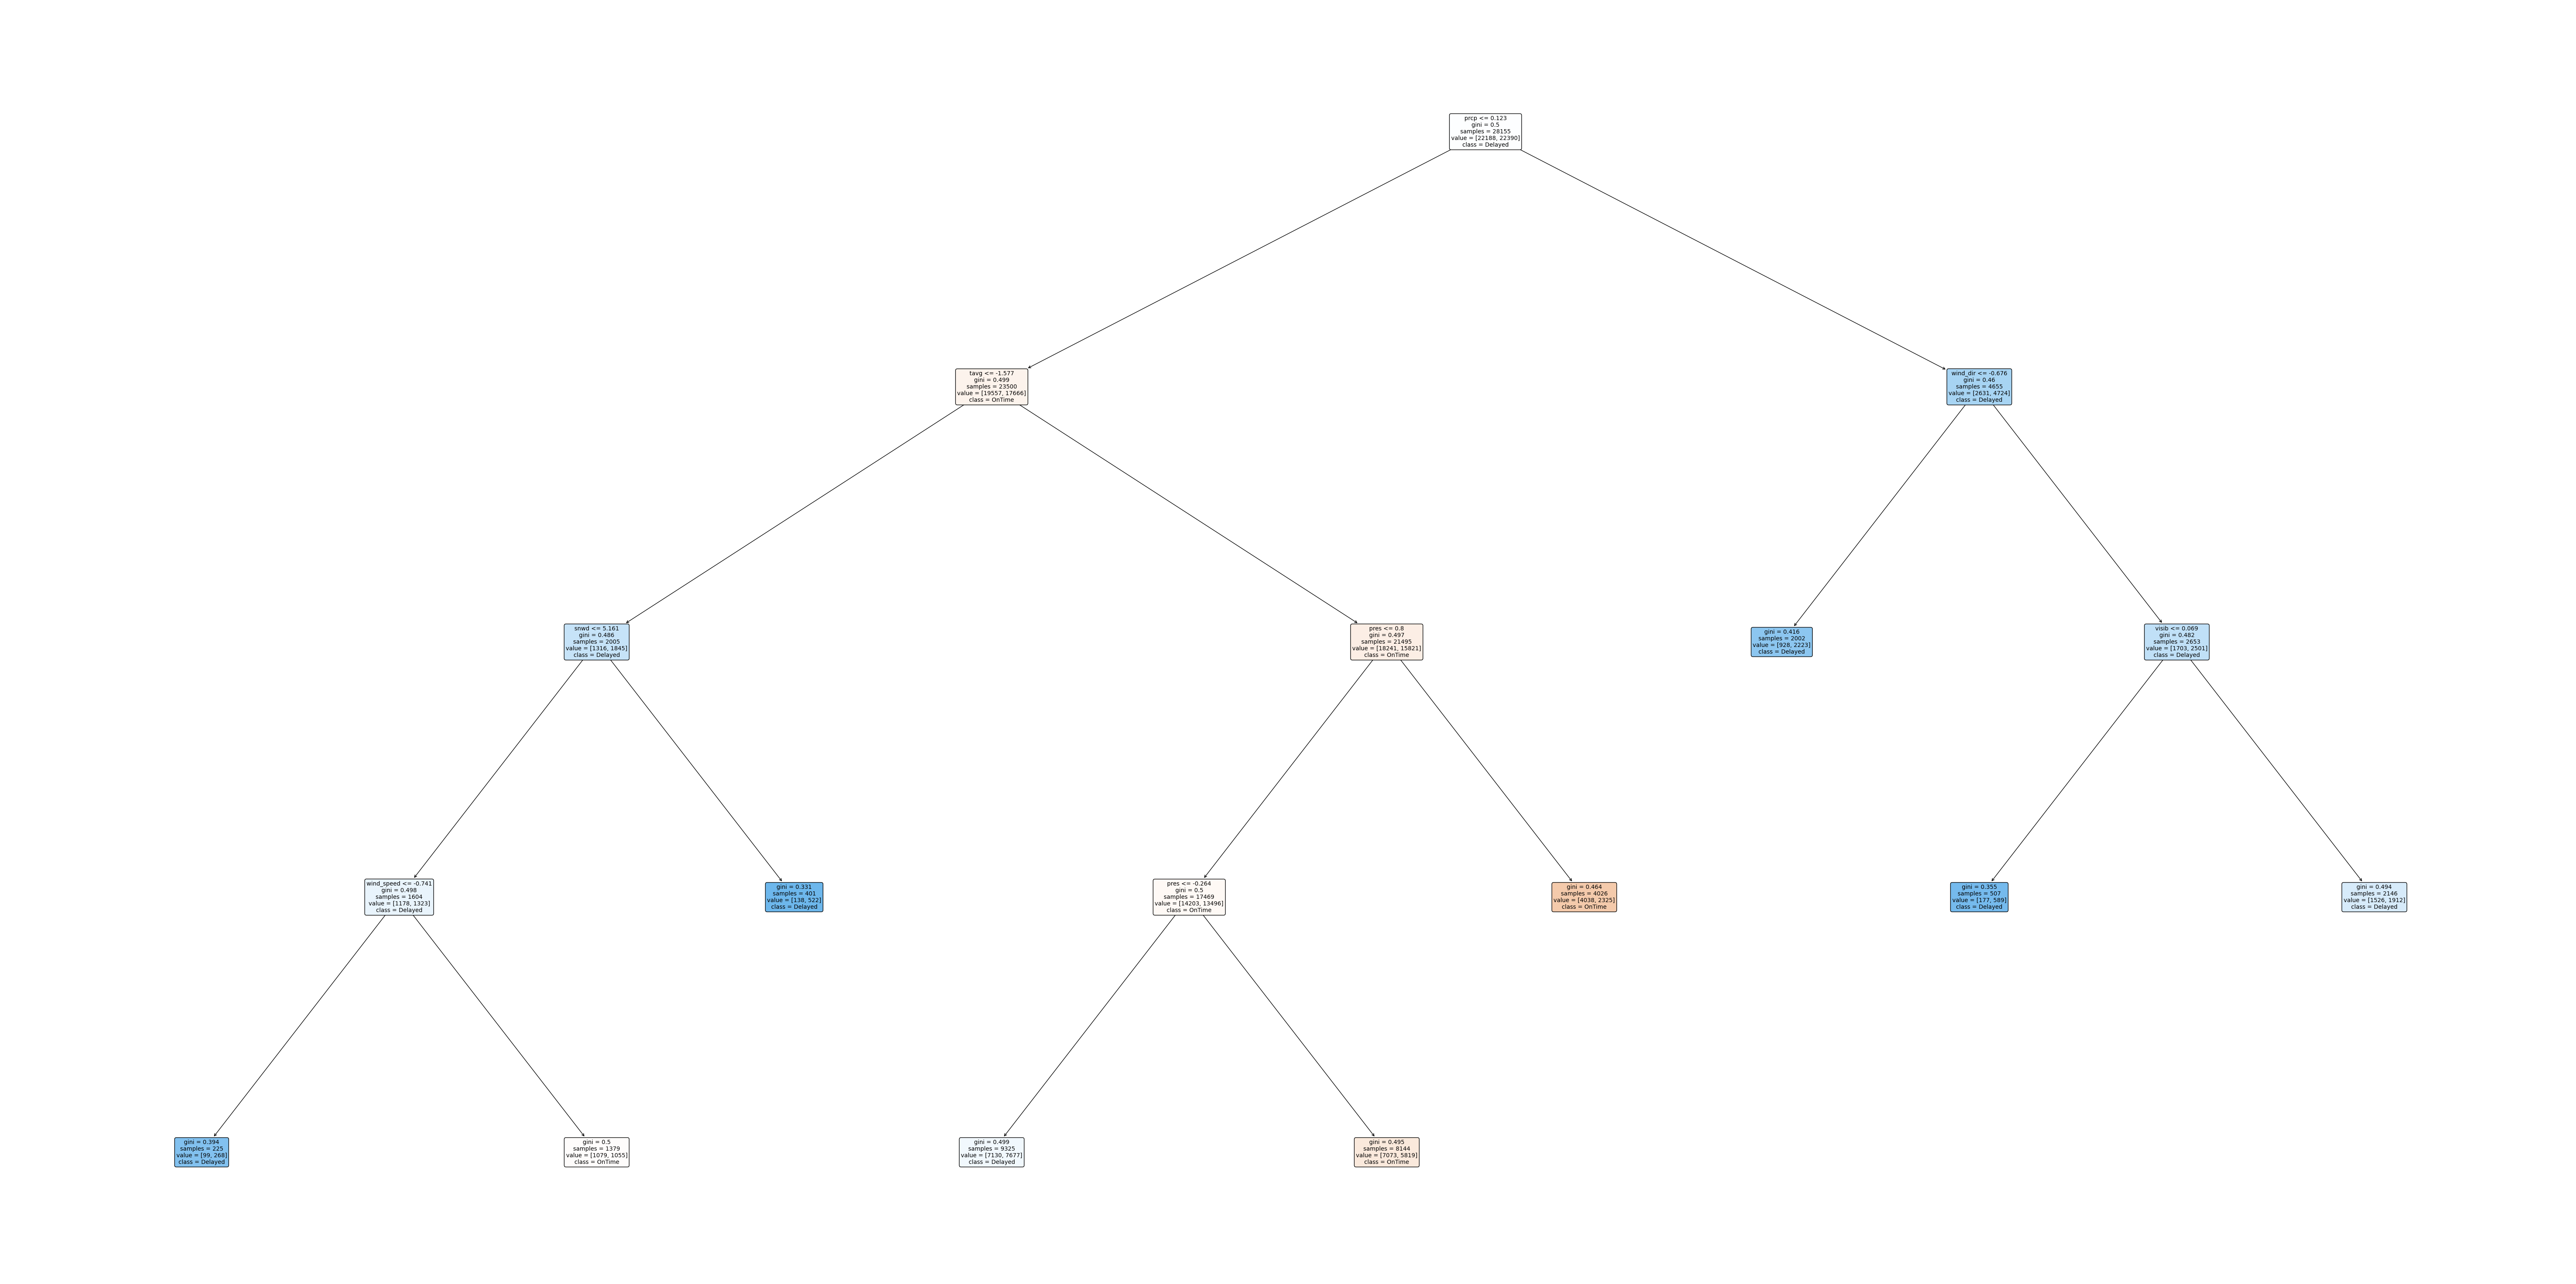

In [19]:
# set the figure size
fig = plt.figure(figsize=(80, 40))

# plot the decision tree
plot_tree(model.estimators_[0], # Pull out one tree from the forest
          max_depth = 5,
          feature_names = ewr_pred_names,
          class_names = ewr_resp_names, 
          filled=True,
          fontsize=10,
          rounded=True)

plt.show()

In [20]:
importances = list(model.feature_importances_)

feature_importances = [(feature, round(importance, 2)) for feature,
                       importance in zip(ewr_pred_names, importances)]

feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

[print('Variable: {:40} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: prcp                                     Importance: 0.37
Variable: pres                                     Importance: 0.21
Variable: visib                                    Importance: 0.17
Variable: snwd                                     Importance: 0.1
Variable: tavg                                     Importance: 0.1
Variable: wind_dir                                 Importance: 0.03
Variable: wind_speed                               Importance: 0.02
Variable: snow                                     Importance: 0.01


## Confusion matrix and classification report

In [21]:
# create balanced test set
bal_ewr_pred_test, bal_ewr_resp_test = ewr_pred_test, ewr_resp_test.copy()
print(Counter(bal_ewr_resp_test))

under = RandomUnderSampler(sampling_strategy=1)
bal_ewr_pred_test, bal_ewr_resp_test = under.fit_resample(bal_ewr_pred_test, bal_ewr_resp_test)
print(Counter(bal_ewr_resp_test))

Counter({0: 17003, 1: 5611})
Counter({0: 5611, 1: 5611})


In [22]:
y_pred = model.predict(bal_ewr_pred_test)
cm = confusion_matrix(bal_ewr_resp_test, y_pred)
cm

array([[3565, 2046],
       [2652, 2959]], dtype=int64)

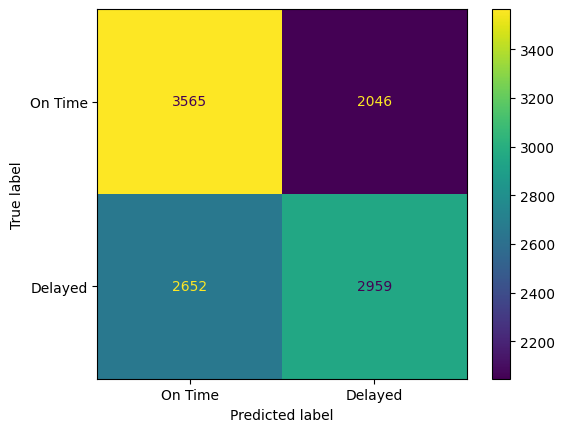

In [23]:
# plot confusion matrix
cm = confusion_matrix(bal_ewr_resp_test, y_pred, labels=model.classes_)
color = 'white'
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["On Time", "Delayed"])
disp.plot()
plt.show()

In [24]:
# get classification report
print(classification_report(bal_ewr_resp_test, y_pred, target_names=['On Time', 'Delayed']))

              precision    recall  f1-score   support

     On Time       0.57      0.64      0.60      5611
     Delayed       0.59      0.53      0.56      5611

    accuracy                           0.58     11222
   macro avg       0.58      0.58      0.58     11222
weighted avg       0.58      0.58      0.58     11222



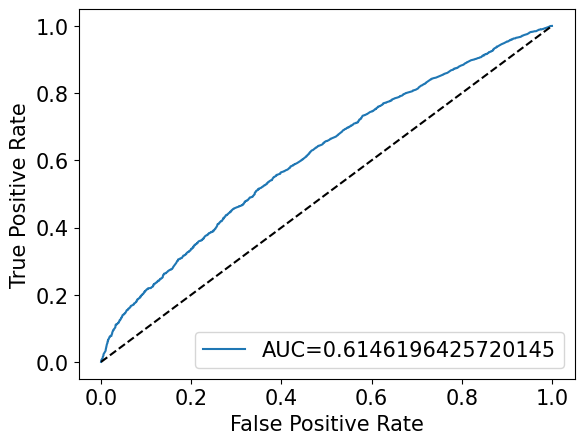

In [25]:
# get ROC curve

y_score = model.predict_proba(bal_ewr_pred_test)[:, 1]

fpr, tpr, threshold = roc_curve(bal_ewr_resp_test, y_score)
auc = roc_auc_score(bal_ewr_resp_test, y_score)
random_probs = [0 for i in range(len(bal_ewr_resp_test))]
p_fpr, p_tpr, threshold = roc_curve(bal_ewr_resp_test, random_probs, pos_label=1)

#create ROC curve
plt.rcParams.update({'font.size': 15})
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.plot(p_fpr, p_tpr, linestyle='--', color='black')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

# Test model with JFK

## Filter airline data

In [26]:
# filter for required airlines
jfk_delay_data = delay_df[delay_df['origin'] == "JFK"].copy()
jfk_delay_data = jfk_delay_data.drop('origin', axis=1)
jfk_delay_data.reset_index(inplace=True, drop=True)
jfk_delay_data.shape

(92481, 9)

In [27]:
# create dummies if required
jfk_delay_data = pd.get_dummies(jfk_delay_data, drop_first = True)
jfk_delay_data.shape

(92481, 9)

## Separate response and scale features

In [28]:
jfk_predictors = jfk_delay_data.drop(columns = 'delayed_flag')
jfk_response = jfk_delay_data['delayed_flag']

In [29]:
# scale features
ss = StandardScaler()
jfk_predictors_scaled = ss.fit_transform(jfk_predictors)
jfk_predictors = pd.DataFrame(jfk_predictors_scaled, columns = jfk_predictors.columns)

In [30]:
# jfk_predictors.mean()

In [31]:
# jfk_predictors.std()

## Test EWR model with new data

In [32]:
# create balanced test set
bal_jfk_pred_test, bal_jfk_resp_test = jfk_predictors, jfk_response.copy()
print(Counter(bal_jfk_resp_test))

under = RandomUnderSampler(sampling_strategy=1)
bal_jfk_pred_test, bal_jfk_resp_test = under.fit_resample(bal_jfk_pred_test, bal_jfk_resp_test)
print(Counter(bal_jfk_resp_test))

Counter({0: 71469, 1: 21012})
Counter({0: 21012, 1: 21012})


In [33]:
y_pred = model.predict(bal_jfk_pred_test)
cm = confusion_matrix(bal_jfk_resp_test, y_pred)
cm

array([[13111,  7901],
       [ 9980, 11032]], dtype=int64)

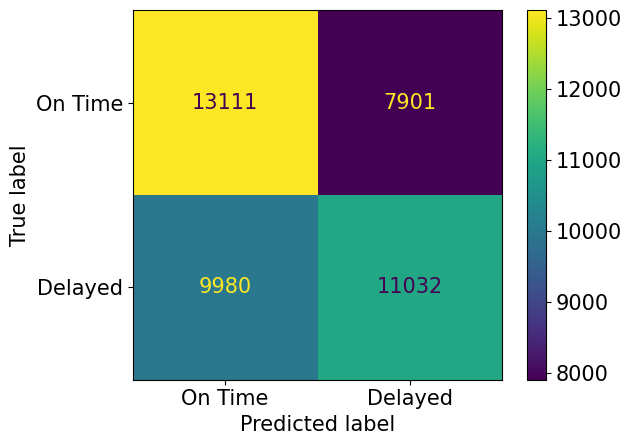

In [34]:
# plot confusion matrix
cm = confusion_matrix(bal_jfk_resp_test, y_pred, labels=model.classes_)
color = 'white'
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["On Time", "Delayed"])
disp.plot()
plt.show()

In [35]:
# get classification report
print(classification_report(bal_jfk_resp_test, y_pred, target_names=['On Time', 'Delayed']))

              precision    recall  f1-score   support

     On Time       0.57      0.62      0.59     21012
     Delayed       0.58      0.53      0.55     21012

    accuracy                           0.57     42024
   macro avg       0.58      0.57      0.57     42024
weighted avg       0.58      0.57      0.57     42024



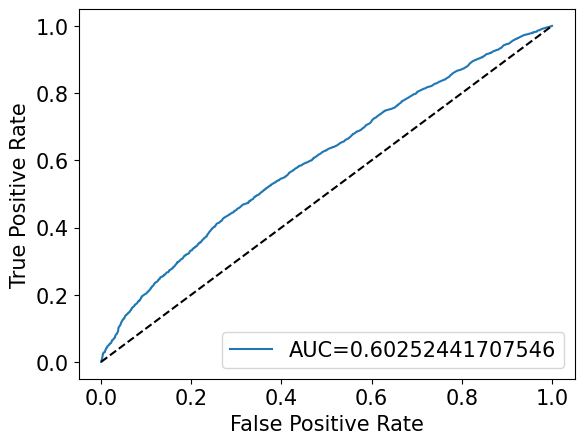

In [36]:
# get ROC curve

y_score = model.predict_proba(bal_jfk_pred_test)[:, 1]

fpr, tpr, threshold = roc_curve(bal_jfk_resp_test, y_score)
auc = roc_auc_score(bal_jfk_resp_test, y_score)
random_probs = [0 for i in range(len(bal_jfk_resp_test))]
p_fpr, p_tpr, threshold = roc_curve(bal_jfk_resp_test, random_probs, pos_label=1)

#create ROC curve
plt.rcParams.update({'font.size': 15})
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.plot(p_fpr, p_tpr, linestyle='--', color='black')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

# Test model with LGA

## Filter airline data

In [37]:
# filter for required airlines
lga_delay_data = delay_df[delay_df['origin'] == "LGA"].copy()
lga_delay_data = lga_delay_data.drop('origin', axis=1)
lga_delay_data.reset_index(inplace=True, drop=True)
lga_delay_data.shape

(90390, 9)

In [38]:
# create dummies if required
lga_delay_data = pd.get_dummies(lga_delay_data, drop_first = True)
lga_delay_data.shape

(90390, 9)

## Separate response and scale features

In [39]:
lga_predictors = lga_delay_data.drop(columns = 'delayed_flag')
lga_response = lga_delay_data['delayed_flag']

In [40]:
# scale features
ss = StandardScaler()
lga_predictors_scaled = ss.fit_transform(lga_predictors)
lga_predictors = pd.DataFrame(lga_predictors_scaled, columns = lga_predictors.columns)

In [41]:
# lga_predictors.mean()

In [42]:
# lga_predictors.std()

## Test EWR model with new data

In [43]:
# create balanced test set
bal_lga_pred_test, bal_lga_resp_test = lga_predictors, lga_response.copy()
print(Counter(bal_lga_resp_test))

under = RandomUnderSampler(sampling_strategy=1)
bal_lga_pred_test, bal_lga_resp_test = under.fit_resample(bal_lga_pred_test, bal_lga_resp_test)
print(Counter(bal_lga_resp_test))

Counter({0: 70784, 1: 19606})
Counter({0: 19606, 1: 19606})


In [44]:
y_pred = model.predict(bal_lga_pred_test)
cm = confusion_matrix(bal_lga_resp_test, y_pred)
cm

array([[12790,  6816],
       [ 8834, 10772]], dtype=int64)

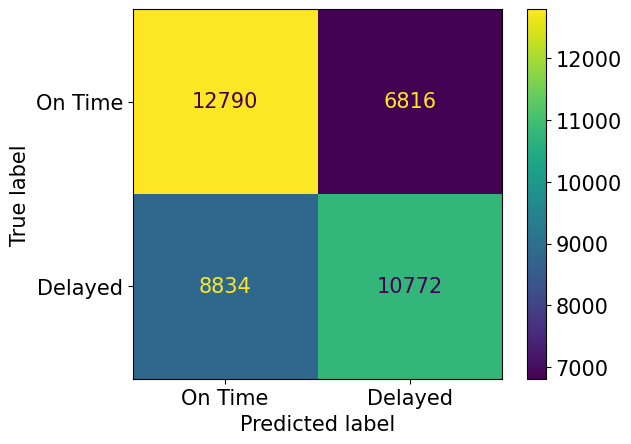

In [45]:
# plot confusion matrix
cm = confusion_matrix(bal_lga_resp_test, y_pred, labels=model.classes_)
color = 'white'
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["On Time", "Delayed"])
disp.plot()
plt.show()

In [46]:
# get classification report
print(classification_report(bal_lga_resp_test, y_pred, target_names=['On Time', 'Delayed']))

              precision    recall  f1-score   support

     On Time       0.59      0.65      0.62     19606
     Delayed       0.61      0.55      0.58     19606

    accuracy                           0.60     39212
   macro avg       0.60      0.60      0.60     39212
weighted avg       0.60      0.60      0.60     39212



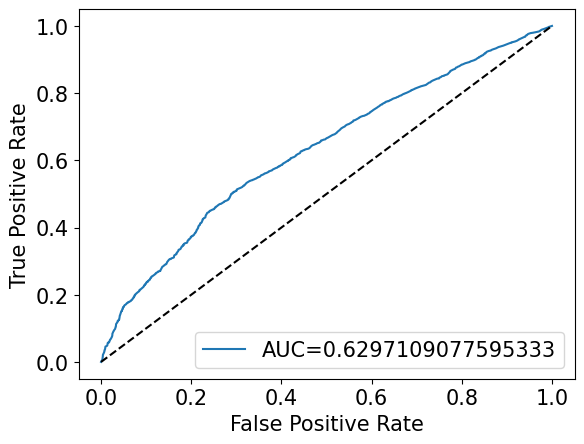

In [47]:
# get ROC curve

y_score = model.predict_proba(bal_lga_pred_test)[:, 1]

fpr, tpr, threshold = roc_curve(bal_lga_resp_test, y_score)
auc = roc_auc_score(bal_lga_resp_test, y_score)
random_probs = [0 for i in range(len(bal_lga_resp_test))]
p_fpr, p_tpr, threshold = roc_curve(bal_lga_resp_test, random_probs, pos_label=1)

#create ROC curve
plt.rcParams.update({'font.size': 15})
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.plot(p_fpr, p_tpr, linestyle='--', color='black')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()